In [15]:
import matplotlib.patches as pch
import matplotlib.pyplot as plt
from numpy import char as ch
import plotly.io as plyio
from PIL import Image
import numpy as np
import math as m
import pickle
import shutil
import json
import os

# !/usr/bin/env python
"""
Functions.py: This file holds a class structure for analyzing .tiff files with diffraction patterns
"""
__outputfolder__ = os.getcwd() + "/outputs/"  # Directory for the folder in which all the outputs are stored
__tiffname__ = "originaltiff"  # Name of the original tiff file which will be output as a .png
__allhighlights__ = "allhighlights"  # Name for the image file that has all of the highlighted areas
__slicehighlight__ = "highlight"  # Prefix for the image file which will highlight individual areas
__sliceplot__ = "sliceplot"  # Prefix for the plots which show the average of the whole slice plotted
__optimizedsliceplot__ = "optimizedsliceplot"  # Prefix for the plots which show the average of the slices, (after they've been halved and overlayed) plotted
__reflectivityplot__ = "reflectivityplot"  # Name for the plot which shows reflectivity


class xray:
    def __init__(self, filename, px, sampledetectdist, wavelength, q1):
        # TODO: Just used for important notes to keep in mind: (X-Chi-Q Parallel) and (Y_Theta-Q Z); 1 px = 0.00122
        """
        __init__ method for xray class. Parameters that are passed through the class are determined by user/machine

        :param filename: Name of the .tiff file that will be run through the class
        :param px: Conversion factor of pixle to millimetres
        :param sampledetectdist: distance between the sample and detector in millimetres
        :param wavelength: xray wavelength in Angstroms
        """
        self.px = px
        self.sampledetectdist = sampledetectdist
        self.xorigin = 0
        self.yorigin = 0
        self.name = filename
        self.wavelength = wavelength
        self.q1 = q1

        ##### Variables declared after this point are properly initialized later in the program #####

        # Image related variables used for loading and manipulation
        self.img = None
        self.imgarr = None
        self.croppedimgarr = None
        self.xdim = 0
        self.ydim = 0
        self.xstart = 0
        self.xend = 0
        self.ystart = 0
        self.yend = 0
        self.index1_1 = 0
        self.index1_2 = 0

        # Objects for holding pixel measurements
        self.pxarr = None
        self.xpxarr = None
        self.ypxarr = None

        # Objects for holding metric measurements
        self.xarr = None
        self.yarr = None

        # Objects for holding angular measurements
        self.chiarr = None
        self.thetaarr = None

        # Variables for holding q space measurements, average and standard deviation
        self.qspacearr = None
        self.qpar = None
        self.qz = None
        self.qpavgstd = None
        self.qzavgstd = None

        # Parameters for .img
        self.headerbytes = 0
        self.sizey = 0
        self.sizex = 0
        self.wavelengthimg = 0.0
        self.amperage = 0.0
        self.voltage = 0.0
        self.energy = 0.0
        self.distortioninfo = None
        self.pixelsize = None
        self.detectorgonioset = None
        self.data = None

        # Variables for holding data for plotting the mean event counts
        self.meandata = []
        self.mdcrops = []
        self.mirroravgs = []
        self.qparcrop = None
        self.index0 = 0
        self.croplen = 0

        # Variables used for holding data to be exported in .dat file
        self.errors = []
        self.ecrops = []
        self.qparpositive = None

        # Variables used for highlighting the slices of interest on the original image
        self.croppedimgs = []
        self.imgwithrectangle = []
        self.points = None

        # Variables used for converting the .tiff files into a json file to allow for interaction with image on the mxray website
        self.datadict = {}
        self.imgjson = {}
        self.outputdict = {}

        self.reflectavg = None
        self.qparposcrop = None
        self.mirroravgcrops = None

        self.tifftoarr()
        self.pop_pxarrs()
        self.pop_metricarrs()
        self.pop_anglearrs()
        self.pop_qspacearrs()

    @staticmethod
    def getindex(arr, point):
        """
        Static method used for finding the index of the entry provided or closest to it in the case of approximation
        by looking for smallest absolute difference between all the entries of the array and the point

        :param arr: Array to be searched
        :param point: Point to be searched for
        :return: index: Index of point or closest point in array
        """
        index = int(np.where(np.abs(arr - point) == np.min(np.abs(arr - point)))[0])
        return index

    @staticmethod
    def tonparray(num, seperator=" "):
        """
        Converts a given string with multiple numbers spaced out with spaces and converts it into a numpy array with each number a float entry

        :param num: A string with multiple numbers in it
        :param seperator: The character that the string will be split around
        :return: arr - A numpy array with float entries
        """
        arr = ch.split(num, seperator).astype(np.float32)
        return arr

    @staticmethod
    def zipoutputs():
        """
        Zips the outputs folder to facilitate downloading of output files for the user
        :return: None
        """

        shutil.make_archive("outputs", "zip", os.getcwd() + "/outputs/")

    def tifftoarr(self):
        """
        Converts the given .tiff file to a NumPy array as well as defining some dimensional variables to streamline certain lines of code

        :return: None
        """
        self.img = Image.open(self.name)
        # noinspection PyTypeChecker
        self.imgarr = np.array(self.img)
        self.xdim = self.imgarr.shape[1]
        self.ydim = self.imgarr.shape[0]

        # Calculates the x coordinate of the origin
        index0 = self.imgarr.argmax()
        index0 = index0 % self.xdim
        self.xorigin = self.xdim - index0

        # Calculates the y coordinate of the origin
        index1 = self.imgarr[:, index0].argmax() + 1
        self.yorigin = self.ydim - index1

    def plottiff(self):
        """
        Plots the provided .tiff file with pixels on axis

        :return: None
        """
        e = [self.qpar[0], self.qpar[-1], self.qz[-1], self.qz[0]]
        plt.figure(1)
        plt.title("Data Set")
        plt.xlabel("Q_||")
        plt.ylabel("Q_z")
        plt.imshow(np.log(self.imgarr + 1), extent=e)

        if os.path.isdir(os.getcwd() + "/outputs/"):
            plt.savefig(os.getcwd() + "/outputs/" + __tiffname__ + ".png")
        else:
            os.makedirs(os.getcwd()+"/outputs/")
            plt.savefig(os.getcwd() + "/outputs/" + __tiffname__ + ".png")
        plt.show()

        plt.close(1)

    def pop_pxarrs(self):
        """
        Populates the pixel arrays, xpxarr and ypxarr, with measurements in pixels

        :return: None
        """
        self.pxarr = np.indices(self.imgarr.shape)
        self.xpxarr = np.linspace(0, self.xdim, self.xdim, False)
        self.ypxarr = np.flip(np.linspace(0, self.ydim, self.ydim, False))

    def pop_metricarrs(self):
        """
        Populates the metric mesurement arrays, xarr and yarr, with measurements in millimetres

        :return: None
        """
        self.yarr = (self.ypxarr - self.yorigin) * self.px
        self.xarr = (self.xpxarr - (self.xdim - self.xorigin)) * self.px

    def pop_anglearrs(self):
        """
        Populates the angular space arrays, thetarr and chiarr, with measurements in degrees

        :return: None
        """
        rad2deg = 360 / (2 * m.pi)
        self.thetaarr = (self.yarr / self.sampledetectdist) * rad2deg
        self.chiarr = np.arctan(self.xarr / self.sampledetectdist) * rad2deg

    def pop_qspacearrs(self):
        """
        Populates the q space arrays, qz and qpar

        :return: None
        """
        deg2rad = 2 * m.pi / 360
        self.qpar = (4 * m.pi * np.sin((self.chiarr / 2) * deg2rad)) / self.wavelength
        self.qz = (4 * m.pi * np.sin(self.thetaarr / 2 * deg2rad)) / self.wavelength

    def cropimg(self, points):
        """
        Crops the given image/colour map based on points provided by the user in a +/-4 px range
        and also plots/shows the images with individual slices highlighted

        :param points: A list or tuple of the points of interest in the image
        :return: None
        """
        rectangles = []
        rectangles2 = []
        self.points = points
        e = [self.qpar[0], self.qpar[-1], self.qz[-1], self.qz[0]]

        for a in points:
            self.croppedimgs.append(self.imgarr[self.getindex(self.qz, a) - 4:self.getindex(self.qz, a) + 4, :])

        for a in points:
            rectangle = pch.Rectangle((e[0], a - 0.00488), e[1] - e[0] - 0.00001, 0.00976, linewidth=1, edgecolor='r',
                                      facecolor='none')
            rectangles.append(rectangle)
            rectangle2 = pch.Rectangle((e[0], a - 0.00488), e[1] - e[0], 0.00976, linewidth=1, edgecolor='r',
                                       facecolor='none')
            rectangles2.append(rectangle2)

        plt.figure(2)
        fig, a = plt.subplots()
        a.imshow(np.log(self.imgarr + 1), extent=e)
        a.title.set_text("Image with all slices highlighted")
        a.set_xlabel("Q_||")
        a.set_ylabel("Q_z")
        for r in rectangles2:
            a.add_patch(r)
        plt.savefig(os.getcwd() + "/outputs/" + __allhighlights__ + ".png")

        for a in range(len(self.points)):
            fig, ax = plt.subplots()
            ax.imshow(np.log(self.imgarr + 1), extent=e)
            ax.title.set_text("Slice of " + str(self.points[a]) + " +/- 4 pixels")
            ax.set_xlabel("Q_||")
            ax.set_ylabel("Q_z")
            ax.add_patch(rectangles[a])
            plt.savefig(os.getcwd() + "/outputs/" + __slicehighlight__ + " " + str(a+1) + ".png")
            plt.show()

        plt.close("2")

    def calcmeanandplot(self):
        """
        Averages the values of the image over the qpar axis, subtracts the background events and plots it

        :return: None
        """

        for a in self.croppedimgs:
            self.meandata.append(np.mean(a, 0))

        for a in self.meandata:
            self.mirroravgs.append(self.qparoptimize(a))

        self.qparpositive = self.qpar[self.index0:self.index0 + self.croplen]

        self.index1_1 = self.getindex(self.qpar, 0.01)
        self.index1_2 = self.getindex(self.qpar, 0.099)

        self.qparcrop = self.qpar[self.index1_1:self.index1_2]

        bgdsample = self.mirroravgs[0]

        ranges = [self.getindex(self.qparpositive, 0.18) - 10, self.getindex(self.qparpositive, 0.18) + 10,
                  self.getindex(self.qparpositive, 0.40) - 10, self.getindex(self.qparpositive, 0.4) + 10]
        bgdpointsx = self.qparpositive[np.r_[ranges[0]:ranges[1], ranges[2]:ranges[3]]]
        bgdpointsy = bgdsample[np.r_[ranges[0]:ranges[1], ranges[2]:ranges[3]]]
        lineparams = np.polyfit(bgdpointsx, bgdpointsy, 1)

        bgd = lambda x: lineparams[0] * x + lineparams[1]

        bgdevents = bgd(self.qparpositive)
        bdgevents2 = bgd(self.qpar)

        for a in range(len(self.meandata)):
            self.mirroravgs[a] = self.mirroravgs[a] - bgdevents
            self.meandata[a] = self.meandata[a] - bdgevents2

        for a in range(len(self.meandata)):
            plt.figure()
            plt.plot(self.qpar, self.meandata[a])
            plt.title("Slice of " + str(self.points[a]) + " +/- 4 pixels")
            plt.xlabel("Q_||")
            plt.savefig(os.getcwd() + "/outputs/" + __sliceplot__ + " " + str(a+1) + ".png")
            plt.show()
            plt.close()

        # plt.figure()
        for a in range(len(self.mirroravgs)):
            plt.figure()
            plt.plot(self.qparpositive, self.mirroravgs[a])
            plt.title("Slice of " + str(self.points[a]) + " +/- 4 pixels")
            plt.xlabel("Q_||")
            plt.savefig(os.getcwd() + "/outputs/" + __optimizedsliceplot__ + " " + str(a+1) + ".png")
            plt.show()
            plt.close()

    def loadimg(self, filename):
        fid = open(filename, 'r')
        fid.readline()
        temp = fid.readline()
        self.headerbytes = int(temp[temp.find("=") + 1:len(temp) - 2])

        for i in range(2):  # Skips 2 Lines
            fid.readline()

        temp = fid.readline()
        self.sizey = int(temp[temp.find("=") + 1:len(temp) - 2])
        temp = fid.readline()
        self.sizex = int(temp[temp.find("=") + 1:len(temp) - 2])

        for i in range(10):  # Skips 10 Lines
            fid.readline()

        temp = fid.readline()
        self.wavelengthimg = float(temp[temp.find(" "):len(temp) - 2])

        temp = fid.readline()
        self.amperage = float(temp[temp.find("=") + 1:len(temp) - 5])

        temp = fid.readline()
        self.voltage = float(temp[temp.find("=") + 1:len(temp) - 5])
        self.energy = self.amperage * self.voltage

        for i in range(21):  # Skips 21 lines
            fid.readline()

        temp = fid.readline()
        # Entries: [xorigin, yorigin, xpx size, ypx size]
        self.distortioninfo = temp[temp.find("=") + 1:len(temp) - 2]
        self.distortioninfo = self.tonparray(self.distortioninfo)
        self.pixelsize = self.distortioninfo[2:]

        for i in range(10):  # Skips 10 lines
            fid.readline()

        temp = fid.readline()
        self.detectorgonioset = temp[temp.find("=") + 1:len(temp) - 2]
        # Entries: [ x pos in deg, y pos in deg, z pos in deg, x pos in mm, y pos in mm, z pos in mm (detector sample distance)]
        self.detectorgonioset = self.tonparray(self.detectorgonioset)

        for i in range(48):  # Skips 48 lines
            fid.readline()

        fid.close()

        fid = open(filename, 'rb')

        fid.seek(self.headerbytes, 0)
        self.data = np.fromfile(fid, np.int32).reshape((self.sizex, self.sizey))
        print(self.data)
        fid.close()

        plt.imshow(np.log(self.data))
        plt.show()

    def qparoptimize(self, arr):
        """
        Optimizes the data by splitting it in the middle at qpar = 0, cropping the edges of pictures as needed to make equivalently sized pieces
        and treating the two sides as different sets of data to eventually average the two and get

        :param arr: Array to be optimized (split, averaged, and possibly plotted)
        :return: None
        """
        self.index0 = self.getindex(self.qpar, 0)
        negativedata = np.flip(arr[:self.index0])
        positivedata = arr[self.index0:]

        self.croplen = positivedata.size
        if negativedata.size < positivedata.size:
            self.croplen = negativedata.size
            positivedata = positivedata[:self.croplen]
        elif negativedata.size > positivedata.size:
            negativedata = negativedata[:self.croplen]

        avgdata = np.mean((negativedata, positivedata), axis=0)

        return avgdata

    def export(self):
        """
        Creates the .dat file that will be run through the subprocess started by the website, and stores it in the outputs folder for later zipping.\\\n

        :return: None
        """
        file = "outputfile.dat"
        fh = open(os.getcwd() + "/outputs/" + file, "w")

        self.index1_1 = self.getindex(self.qparpositive, 0.01)
        self.index1_2 = self.getindex(self.qparpositive, 0.099)

        self.qparposcrop = self.qparpositive[self.index1_1:self.index1_2]

        for a in self.mirroravgs:
            self.errors.append(np.ones_like(a))

        self.mirroravgcrops = []
        for a in range(len(self.mirroravgs)):
            self.mirroravgcrops.append(self.mirroravgs[a][self.index1_1:self.index1_2])
            self.ecrops.append(self.errors[a][self.index1_1:self.index1_2])

        data = self.qparposcrop
        for a in range(len(self.mirroravgcrops)):
            data = np.column_stack((data, self.mirroravgcrops[a], self.ecrops[a]))

        fmt = '%4.4f'
        header = ("{"
                  "\nNUMLINES=" + str(6 + len(self.points)) +
                  "\nFILENAME=" + self.name +
                  "\nNUMDATLINES=" + str(len(self.qparposcrop)) +
                  "\nQ1=" + str(self.q1))

        for a in self.points:
            header = header + "\nQZSTART=" + str(a)

        header = header + "\n}"

        np.savetxt(os.getcwd() + "/outputs/" + file, data, fmt=fmt, header=header, comments='')

        fh.close()

        datadict = json.dumps(self.datadict)
        with open(os.getcwd() + "/outputs/" + "heatmaps.json", "w") as outfile:
            outfile.write(datadict)

    def datadictjsons(self):
        """
        Creates dictionary entries used for json files. \\\n
        First entry, key: "0" has the regular unmodified image\\\n
        Second entry, key: "1" has the image with the the areas of interest highlighted\\\n
        Third entry, key: "2" has the reflectivity graph used for identifying Q1\\\n

        :return: None
        """
        self.data = {}
        self.data["0"] = {
            "z": np.log(self.imgarr + 1).tolist(),
            "x": self.qpar.tolist(),
            "y": self.qz.tolist(),
            "type": "heatmap",
        }

        temp = self.imgarr.copy()
        for a in self.points:
            pointindex = self.getindex(self.qz, a)
            maxentry = np.max(temp)
            temp[pointindex + 4] = maxentry
            temp[pointindex - 4] = maxentry

        self.data["1"] = {
            "z": np.log(temp + 1).tolist(),
            "x": self.qpar.tolist(),
            "y": self.qz.tolist(),
            "type": "heatmap",
        }

        self.data["2"] = {
            "x": np.log(self.reflectavg),
            "y": self.qz,
            "type": "scatter"
        }

        # outputjson = json.dumps(data["0"], indent=4)
        #
        # with open(__outputfolder__ + "test.json", 'w') as fh:
        #     fh.write(outputjson)
        #
        # output = plyio.read_json(os.getcwd() + "/outputs/test.json")
        # output.show()

        # return data

    def plotreflectivity(self):
        """
        Plots the reflectivity by taking a slice of the image around the origin of the picture in a -/+6 px range and puts it in an array

        :return: None
        """
        reflection = self.imgarr[:, (self.xdim-self.xorigin-6):(self.xdim-self.xorigin+6)]
        plt.figure()
        plt.title("Beam Reflectivity Slice")
        plt.xticks([])
        plt.imshow(np.log(reflection + 1))
        
        plt.show()
        plt.close()

        plt.figure()
        self.reflectavg = np.average(reflection, axis=1)
        plt.plot(self.qz, np.log(self.reflectavg))
        plt.title("Reflectivity")
        plt.xlabel("Q_Z")
        plt.ylabel("log(I)")
        plt.savefig(os.getcwd() + "/outputs/" + __reflectivityplot__ + ".png")
        plt.show()
        plt.close()

    def pickleme(self):
        with open(os.getcwd() + "/outputs/xrayobj.pkl", "wb") as fh:
            pickle.dump(self, fh)
        self.img.close()


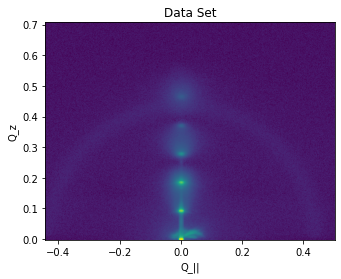

<Figure size 432x288 with 0 Axes>

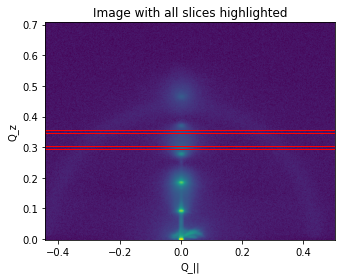

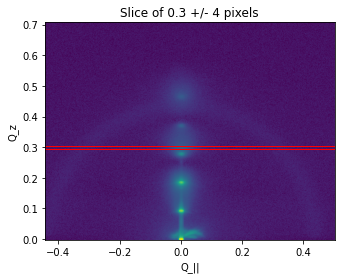

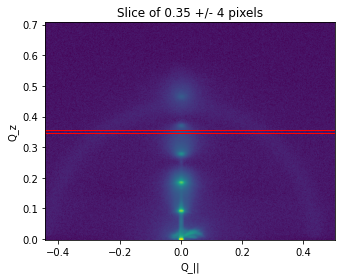

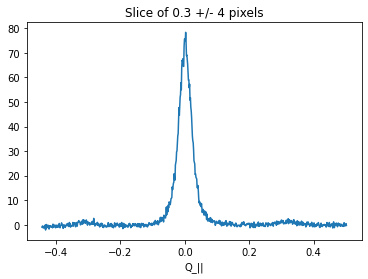

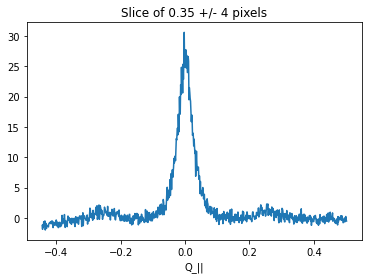

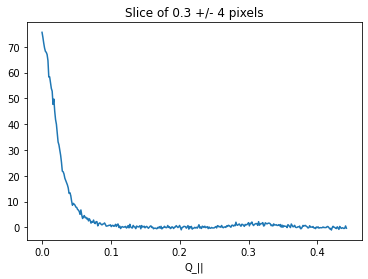

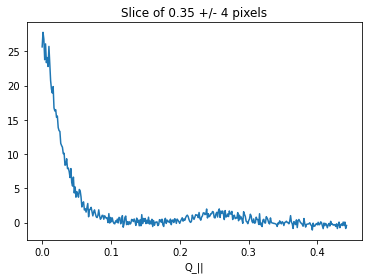

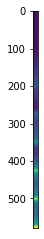

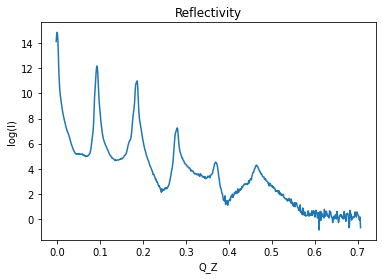

In [16]:
if __name__ == '__main__':
	a = xray(filename="testoutput32Bit.tiff", px=0.1, sampledetectdist=332.1269, wavelength=1.541867, q1=0.0945)
	a.plottiff()
	a.cropimg([0.3, 0.35])
	a.calcmeanandplot()
	a.plotreflectivity()
	a.datadictjsons()
	a.export()
	a.pickleme()
	a.zipoutputs()